In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN/SiKAN/')  # Add the directory to Python's path

from SincKANLayer import SincKANLayer



Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from SincKANLayer import SincKANLayer


In [3]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0.2, y.shape)
    y += noise

    return y

In [4]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


class SincKAN(nn.Module):
    def __init__(self):
        super(SincKAN, self).__init__()
        self.Sinckan1 = SincKANLayer(1, 8, 8)
        self.Sinckan2 = SincKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.Sinckan1(x)
        x = self.Sinckan2(x)
        return x

In [5]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
Sinc_model = SincKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_Sinc = torch.optim.Adam(Sinc_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

Sinc_losses = []
mlp_losses = []

# Train the models
epochs = 2000
for epoch in range(epochs):
    optimizer_Sinc.zero_grad()
    outputs_Sinc = Sinc_model(x_train)
    loss_Sinc = criterion(outputs_Sinc, y_train)
    loss_Sinc.backward()
    optimizer_Sinc.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        Sinc_losses.append(loss_Sinc.item())
        mlp_losses.append(loss_mlp.item())
        print(f'Epoch {epoch + 1}/{epochs}, SincKAN Loss: {loss_Sinc.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_Sinc = Sinc_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

Epoch 1/2000, SincKAN Loss: 0.6895, MLP Loss: 0.9386
Epoch 101/2000, SincKAN Loss: 0.0317, MLP Loss: 0.2404
Epoch 201/2000, SincKAN Loss: 0.0281, MLP Loss: 0.2388
Epoch 301/2000, SincKAN Loss: 0.0274, MLP Loss: 0.2374
Epoch 401/2000, SincKAN Loss: 0.0263, MLP Loss: 0.2347
Epoch 501/2000, SincKAN Loss: 0.0252, MLP Loss: 0.2316
Epoch 601/2000, SincKAN Loss: 0.0261, MLP Loss: 0.2294
Epoch 701/2000, SincKAN Loss: 0.0243, MLP Loss: 0.2285
Epoch 801/2000, SincKAN Loss: 0.0240, MLP Loss: 0.2280
Epoch 901/2000, SincKAN Loss: 0.0243, MLP Loss: 0.2274
Epoch 1001/2000, SincKAN Loss: 0.0243, MLP Loss: 0.2268
Epoch 1101/2000, SincKAN Loss: 0.0231, MLP Loss: 0.2277
Epoch 1201/2000, SincKAN Loss: 0.0237, MLP Loss: 0.2257
Epoch 1301/2000, SincKAN Loss: 0.0224, MLP Loss: 0.2253
Epoch 1401/2000, SincKAN Loss: 0.0223, MLP Loss: 0.2250
Epoch 1501/2000, SincKAN Loss: 0.0219, MLP Loss: 0.2240
Epoch 1601/2000, SincKAN Loss: 0.0220, MLP Loss: 0.2232
Epoch 1701/2000, SincKAN Loss: 0.0218, MLP Loss: 0.2224
Epoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

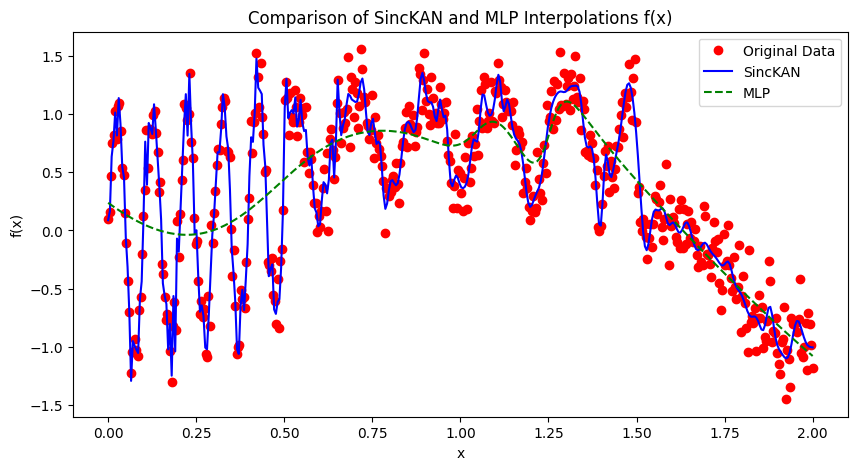

In [6]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_Sinc.numpy(), 'b-', label='SincKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of SincKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

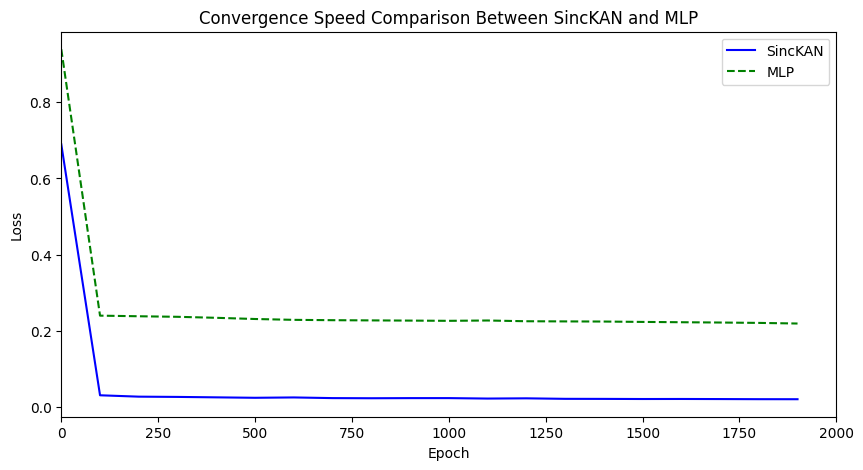

In [7]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), Sinc_losses, 'b-', label='SincKAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.title('Convergence Speed Comparison Between SincKAN and MLP')
plt.xlim(0, 2000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()